In [2]:
import numpy as np 
import pandas as pd 
from sklearn import model_selection
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from scipy.stats import mode
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import optuna
from category_encoders import TargetEncoder
import re
from sklearn.feature_selection import SelectFromModel

In [3]:
df = pd.read_csv("/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/objects_train_kfold.csv")
df_test=pd.read_csv("/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/objects_test.csv")

df_outputs=df_test['Output']

df

,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,...,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,Output,kfold
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2600,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
2601,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
2602,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


75


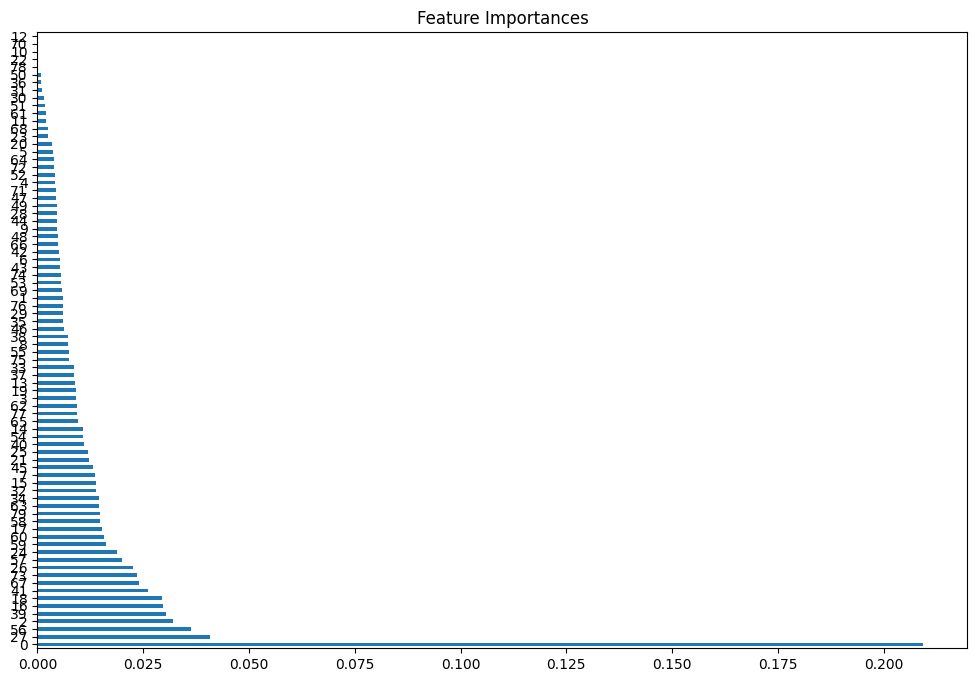

In [4]:
train_features = df.drop(columns=["kfold", "Output"])
train_targets = df["Output"]

train_features.columns = train_features.columns.astype(str)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)

# Fit the classifier
clf.fit(train_features, train_targets)

# Create a DataFrame to visualize feature importances
features_importance = pd.DataFrame()
features_importance['feature'] = train_features.columns
features_importance['importance'] = clf.feature_importances_
features_importance.sort_values(by=['importance'], ascending=False, inplace=True)

# Visualize feature importances
features_importance.plot(kind='barh', figsize=(12, 8), legend=False, title='Feature Importances')

# Choose the top k most important features
# k = 27 # Adjust this value based on your preference or analysis
# selected_features = features_importance.head(k)['feature'].tolist()
selected_features = []

# Iterate over rows of the DataFrame
for index, row in features_importance.iterrows():
    if row['importance'] > 0:
        selected_features.append(row['feature'])

print(len(selected_features))

In [5]:
final_predictions = []

# def run(trial):
accuracy_scores=[]

save_dir = "/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main"

for fold in range(5):

    # learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    # reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    # reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    # subsample = trial.suggest_float("subsample", 0.1, 1.0)
    # colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    # max_depth = trial.suggest_int("max_depth", 1, 7)
    # n_estimators = trial.suggest_int("n_estimators", 50, 1000)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    xtest=xtest[selected_features]

    ytrain = xtrain.Output
    yvalid = xvalid.Output

    xtrain = xtrain[selected_features]
    xvalid = xvalid[selected_features]
    

    # Select categorical columns
#     categorical_cols = [cname for cname in xtrain.columns if
#                         xtrain[cname].nunique() < 10 and 
#                         xtrain[cname].dtype == "object"]

#     # Select numerical columns
#     numerical_cols = [cname for cname in xtrain.columns if 
#                       xtrain[cname].dtype in ['int64', 'float64']]

#     # Keep selected columns only
#     my_cols = categorical_cols + numerical_cols

#     # Normalization((x-mu)/sigma)

#     scaler = preprocessing.StandardScaler()
#     xtrain[numerical_cols_1] = scaler.fit_transform(xtrain[numerical_cols_1])
#     xvalid[numerical_cols_1] = scaler.transform(xvalid[numerical_cols_1])
#     xtest[numerical_cols_1] = scaler.transform(xtest[numerical_cols_1])

    # Define model
    model = XGBClassifier(n_estimators=100, learning_rate=0.024730958937285503,reg_lambda=0.05700749049362695,reg_alpha=2.0016890542272904e-06,subsample=0.8163423623945554,max_depth=4,n_jobs=5)

    model.fit(xtrain, ytrain)

    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_predictions.append(test_preds)
    print(fold, accuracy_score(yvalid, preds_valid))
    
    accuracy_scores.append(accuracy_score(yvalid, preds_valid))

    model_filename = os.path.join(save_dir,f"model_{fold+1}.h5")
    model.save_model(model_filename)
# return np.mean(accuracy_scores) 

0 0.5299625468164794
1 0.5152091254752852
2 0.5447470817120622


/home/lenovo/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:42:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/lenovo/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:42:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/lenovo/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:42:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


3 0.5780346820809249
4 0.5401174168297456


/home/lenovo/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:42:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/lenovo/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:42:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [15]:
# final_predictions = []

# def run(trial):
#     accuracy_scores=[]

#     for fold in range(5):

#         learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
#         reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
#         reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
#         subsample = trial.suggest_float("subsample", 0.1, 1.0)
# #         colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
#         max_depth = trial.suggest_int("max_depth", 1, 7)
# #         n_estimators = trial.suggest_int("n_estimators", 50, 1000)

#         xtrain = df[df.kfold != fold].reset_index(drop=True)
#         xvalid = df[df.kfold == fold].reset_index(drop=True)
# #         xtest = df_test.copy()

# #         xtest=xtest[selected_features]

#         ytrain = xtrain.Output
#         yvalid = xvalid.Output

#         xtrain = xtrain[selected_features]
#         xvalid = xvalid[selected_features]


#         # Select categorical columns
#     #     categorical_cols = [cname for cname in xtrain.columns if
#     #                         xtrain[cname].nunique() < 10 and 
#     #                         xtrain[cname].dtype == "object"]

#     #     # Select numerical columns
#     #     numerical_cols = [cname for cname in xtrain.columns if 
#     #                       xtrain[cname].dtype in ['int64', 'float64']]

#     #     # Keep selected columns only
#     #     my_cols = categorical_cols + numerical_cols

#     #     # Normalization((x-mu)/sigma)

#     #     scaler = preprocessing.StandardScaler()
#     #     xtrain[numerical_cols_1] = scaler.fit_transform(xtrain[numerical_cols_1])
#     #     xvalid[numerical_cols_1] = scaler.transform(xvalid[numerical_cols_1])
#     #     xtest[numerical_cols_1] = scaler.transform(xtest[numerical_cols_1])

#         # Define model
#         model = XGBClassifier(n_estimators=100, learning_rate=learning_rate,reg_lambda=reg_lambda,reg_alpha=reg_alpha,subsample=subsample,max_depth=max_depth,n_jobs=5)

#         model.fit(xtrain, ytrain)

#         preds_valid = model.predict(xvalid)
# #         test_preds = model.predict(xtest)
# #         final_predictions.append(test_preds)
#         print(fold, accuracy_score(yvalid, preds_valid))

#         accuracy_scores.append(accuracy_score(yvalid, preds_valid))
        
#     return np.mean(accuracy_scores) 

In [16]:


# # # Optimization

# study = optuna.create_study(direction="maximize")
# study.optimize(run, n_trials=20)



[I 2024-02-16 23:00:08,324] A new study created in memory with name: no-name-d366e17f-9679-436a-9673-89e40e014228
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.sugges

0 0.5149812734082397
1 0.4790874524714829
2 0.4708171206225681
3 0.5067437379576107


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

4 0.5146771037181996
0 0.5337078651685393
1 0.49619771863117873
2 0.5486381322957199


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.558766859344894
4 0.5362035225048923
0 0.5318352059925093
1 0.4923954372623574


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

2 0.5311284046692607
3 0.5626204238921002


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
[I 2024-02-16 23:00:09,442] Trial 2 finished with value: 0.5312279882967094 and parameters: {'learning_rate': 0.16688084651994642, 'reg_lambda': 3.5582816428190065e-07, 'reg_alpha': 1.05187099789142, 'subsample': 0.21665057755148504, 'max_depth': 2}. Best is trial 1 with value: 0.5347028195890449.
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been depr

4 0.538160469667319
0 0.5112359550561798
1 0.5057034220532319
2 0.48249027237354086


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.5240847784200385
4 0.5303326810176126
0 0.5318352059925093


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.49809885931558934
2 0.5350194552529183
3 0.5703275529865125
4 0.5283757338551859


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5243445692883895
1 0.5171102661596958
2 0.519455252918288


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.5568400770712909
4 0.5283757338551859
0 0.5280898876404494


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.5
2 0.5330739299610895
3 0.5684007707129094


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
[I 2024-02-16 23:00:10,850] Trial 6 finished with value: 0.5339364010288389 and parameters: {'learning_rate': 0.06702038931345139, 'reg_lambda': 2.2694187787710445, 'reg_alpha': 4.946011287086437e-05, 'subsample': 0.468933967661617, 'max_depth': 3}. Best is trial 1 with value: 0.5347028195890449.
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been depre

4 0.5401174168297456
0 0.5318352059925093
1 0.5076045627376425


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

2 0.5369649805447471
3 0.5549132947976878
4 0.5342465753424658
0 0.5280898876404494


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.5209125475285171
2 0.5291828793774319
3 0.5510597302504817
4 0.5401174168297456


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5224719101123596
1 0.5285171102661597
2 0.5175097276264592


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.5741811175337187
4 0.5342465753424658
0 0.5449438202247191


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.5190114068441065
2 0.5272373540856031
3 0.5433526011560693


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

4 0.538160469667319
0 0.5318352059925093
1 0.5152091254752852


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

2 0.5214007782101168
3 0.5645472061657033
4 0.547945205479452


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5299625468164794
1 0.5152091254752852
2 0.5447470817120622


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.5780346820809249
4 0.5401174168297456
0 0.5318352059925093


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.5171102661596958
2 0.5175097276264592
3 0.5606936416184971


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
[I 2024-02-16 23:00:13,554] Trial 13 finished with value: 0.5326704727804107 and parameters: {'learning_rate': 0.027128345516424096, 'reg_lambda': 0.019385216480486973, 'reg_alpha': 2.0565472599853383e-06, 'subsample': 0.7477678845245552, 'max_depth': 4}. Best is trial 12 with value: 0.5416141705828995.
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has bee

4 0.5362035225048923
0 0.5355805243445693
1 0.5114068441064639


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

2 0.5428015564202334
3 0.5491329479768786
4 0.5440313111545988


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5411985018726592
1 0.5114068441064639
2 0.5291828793774319


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

3 0.5529865125240848
4 0.5459882583170255
0 0.5430711610486891


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

1 0.5038022813688213
2 0.5525291828793775
3 0.5606936416184971
4 0.5283757338551859


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5430711610486891
1 0.5038022813688213
2 0.5525291828793775
3 0.5606936416184971


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

4 0.538160469667319
0 0.5374531835205992
1 0.5057034220532319


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

2 0.5389105058365758
3 0.5722543352601156
4 0.5342465753424658


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform ha

0 0.5318352059925093
1 0.5057034220532319
2 0.5252918287937743


/tmp/ipykernel_8612/4070836588.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
/tmp/ipykernel_8612/4070836588.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
[I 2024-02-16 23:00:15,958] Trial 19 finished with value: 0.5357990887397872 and parameters: {'learning_rate': 0.07277438596041774, 'reg_lambda': 0.4960250530244934, 'reg_alpha': 0.05170580173258259, 'subsample': 0.3963350727336147, 'max_depth': 1}. Best is trial 12 with value: 0.5416141705828995.


3 0.5799614643545279
4 0.5362035225048923


In [17]:
# # # Best parameters

# study.best_params

{'learning_rate': 0.024730958937285503,
 'reg_lambda': 0.05700749049362695,
 'reg_alpha': 2.0016890542272904e-06,
 'subsample': 0.8163423623945554,
 'max_depth': 4}

In [6]:
preds = np.mean(np.column_stack(final_predictions), axis=1)

print(preds)

preds_final=np.where(preds >= 0.5, 1, 0)

print(preds_final)

print(df_outputs)

print(accuracy_score(preds_final,df_outputs))

[1.  0.6 1.  1.  0.8 0.6 0.  0.6 0.  0.  0.  1.  0.  0.6 1.  0.6 1.  1.
 0.6 1.  0.6 0.6 1.  1.  1.  1.  1.  0.4 0.  1.  1.  1.  0.8 1.  0.  0.
 0.6 1.  1.  0.4 1.  0.6 1.  0.6 0.4 1.  1.  1.  1.  1.  1.  1.  0.6 1.
 0.6 1.  1.  0.  1.  0.8 1.  1.  1.  1.  0.  1.  1.  0.6 0.6 1.  1.  1.
 1.  0.4 1.  0.  0.8 1.  0.  1.  1.  0.2 0.8 1.  1.  1.  1.  1.  1.  0.6
 1.  1.  1.  0.2 1.  0.  0.  1.  0.4 0.2 1.  0.6 0.6 1.  1.  1.  1.  0.
 1.  1.  1.  0.6 0.  1.  1.  0.8 1.  1.  0.  0.4 1.  0.  0.6 1.  1.  0.
 0.2 0.  1.  0.2 1.  0.  0.  1.  1.  0.6 1.  0.4 0.6 0.6 1.  0.  0.8 1.
 0.  1.  0.6 0.8 0.2 0.8 1.  1.  0.6 1.  0.  1.  0.8 0.6 1.  0.8 1.  1.
 1.  1.  1.  1.  0.2 1.  0.  1.  0.  1.  0.  0.6 0.4 1.  0.  1.  0.6 1.
 0.  0.  0.  1.  0.6 1.  0.  1.  1.  1.  0.2 1.  1.  1.  1.  1.  1.  1.
 0.4 0.  1.  0.2 0.  0.  0.6 0.6 1.  1.  1.  1.  0.  0.  1.  1.  0.6 0.4
 0.6 0.  0.  0.6 0.4 0.8 0.  0.6 1.  0.  1.  0.8 0.  1.  0.6 0.8 1.  0.6
 1.  1.  1.  0.4 0.8 0.6 0.4 1.  1.  0.2 0.6 0.  1.  0.  0.6 

In [8]:
import os
import re
from functools import partial
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
import torch
import torch.nn as nn
from ultralytics import YOLO
import itertools
from collections import Counter
import json

text_model = torch.load("bert_hate_classification_model.pth")

# Define text preprocessing functions
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Modify this path accordingly
SLANG_PATH = "static/slang.txt"

with open(SLANG_PATH) as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
                     for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True)
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def text_preprocessing(final):
    preprocessed_text = []
    for sentence in final:
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = replaceSlang(sentence)
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        preprocessed_text.append(sentence.strip())
    return preprocessed_text

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
yolo_model=YOLO("yolov8m.pt")


classes_dict = {index: feature for index, feature in enumerate(selected_features)}

# Create an empty DataFrame
object_df = pd.DataFrame(columns=classes_dict.values())

In [14]:

combined_prediction=[]
combined_reality=[]

def predict_text_hatefulness(model, tokenizer, directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            # Construct the full file path
            new_filename = os.path.splitext(filename)[0] + ".png"

            search_img_path = "img/" + new_filename
            
            file_path = os.path.join(directory_path, filename)
            image_file_path = os.path.join(directory_path.replace("texts", "images"), new_filename)

            results = yolo_model.predict(image_file_path)
            result = results[0]  
            detected_objects = [result.names[box.cls[0].item()] for box in result.boxes]
            
            # Count the occurrences of each object
            object_counts = Counter(detected_objects)
            
            # Create dictionary to store the frequency of each object
            object_freq = {obj: object_counts.get(obj, 0) for obj in object_df.columns}
            # print(selected_features)
            
            predictions=[]

            for fold in range(1, 6):
                # Load the model
                model_filename = f"model_{fold}.h5"
                loaded_model = XGBClassifier()
                loaded_model.load_model(model_filename)
            
                # Make predictions and append to the list
                data_for_prediction = [list(object_freq.values())]
                
                predictions.append(loaded_model.predict(data_for_prediction))

            image_prediction=np.mean(predictions)
            
            # Read text from file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()

            # Preprocess the text
            text = text_preprocessing([text])[0]

            # Tokenize the text
            inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding=True)

            # Perform inference
            with torch.no_grad():
                input_ids = inputs['input_ids']
                attention_mask = inputs['attention_mask']
                outputs = text_model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probabilities = nn.functional.softmax(logits, dim=1)

                final_probability=(probabilities[0][0]+image_prediction)/2
                
                combined_prediction.append(final_probability)

                with open("/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/hateful_memes/test_seen.jsonl", "r") as file:
                    for line in file:
                        data = json.loads(line)
                        if data["img"] == search_img_path:
                            combined_reality.append(data["label"])
                            break

# Example usage:
directory_path_1 = "/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/texts/1"
directory_path_0 = "/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/texts/0"

predict_text_hatefulness(model, tokenizer, directory_path_1)
predict_text_hatefulness(model, tokenizer, directory_path_0)


image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/50348.png: 448x640 1 person, 6545.7ms
Speed: 36.3ms preprocess, 6545.7ms inference, 41.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/05462.png: 640x512 1 person, 1 tie, 1113.4ms
Speed: 4.4ms preprocess, 1113.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/18750.png: 448x640 2 persons, 1 bowl, 2 donuts, 5 cakes, 1585.7ms
Speed: 2.3ms preprocess, 1585.7ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/26391.png: 640x480 2 persons, 835.3ms
Speed: 7.8ms preprocess, 835.3ms inference, 1.2ms postprocess per imag

/tmp/ipykernel_21064/95453798.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').get_text()


image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/08524.png: 448x640 6 persons, 803.9ms
Speed: 2.4ms preprocess, 803.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/64803.png: 448x640 1 person, 805.4ms
Speed: 3.9ms preprocess, 805.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/94380.png: 448x640 1 person, 814.5ms
Speed: 4.0ms preprocess, 814.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/dataset_hate/test/images/1/10287.png: 448x640 1 person, 2 ties, 647.2ms
Speed: 3.6ms preprocess, 647.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1

In [8]:
# combined_prediction = [tensor.item() for tensor in combined_prediction]
print(combined_prediction)

print(combined_reality)

for i in range(len(combined_prediction)):
    if combined_prediction[i] >= 0.5:
        combined_prediction[i]=1
    else:
        combined_prediction[i]=0
        
print(accuracy_score(combined_prediction,combined_reality))

NameError: name 'combined_prediction' is not defined

In [9]:
image_file_path="/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/images/46971.png"
text_file_path="/home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/images/46971.txt"

results = yolo_model.predict(image_file_path)
result = results[0]  
detected_objects = [result.names[box.cls[0].item()] for box in result.boxes]
            
# Count the occurrences of each object
object_counts = Counter(detected_objects)
            
# Create dictionary to store the frequency of each object
object_freq = {obj: object_counts.get(obj, 0) for obj in object_df.columns}

predictions=[]

for fold in range(1, 6):
    # Load the model
    model_filename = f"model_{fold}.h5"
    loaded_model = XGBClassifier()
    loaded_model.load_model(model_filename)
            
    # Make predictions and append to the list
    data_for_prediction = [list(object_freq.values())]
                
    predictions.append(loaded_model.predict(data_for_prediction))

img_prediction=np.mean(predictions)


def predict_text_hatefulness(tokenizer, text_file_path):
    # Read text from file
    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Preprocess the text
    text = text_preprocessing([text])[0]

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding=True)

    # Perform inference
    with torch.no_grad():
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = text_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = nn.functional.softmax(logits, dim=1)
        
    return probabilities[0][0]

text_prediction=predict_text_hatefulness(tokenizer, text_file_path)

hate_list=['Non-Hateful','Hateful']

img_prediction = img_prediction >= 0.5
text_prediction =text_prediction >= 0.5

print(f"Image analysis predicts it as {hate_list[img_prediction]}")
print(f"Text analysis predicts it as {hate_list[text_prediction]}")

final_prediction=(img_prediction+text_prediction)/2

final_prediction =final_prediction >= 0.5

print(f"Multimodal analysis predicts it as {hate_list[final_prediction]}")


image 1/1 /home/lenovo/Documents/Computer Vision/streamlit-hatefulmemedection-main/images/46971.png: 640x448 10 persons, 1 handbag, 281.5ms
Speed: 3.8ms preprocess, 281.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 448)
Image analysis predicts it as Hateful
Text analysis predicts it as Hateful
Multimodal analysis predicts it as Hateful


/tmp/ipykernel_19042/2848172576.py:58: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f"Image analysis predicts it as {hate_list[img_prediction]}")
